# Diagnóstico de Receita e Políticas de Desconto

Este notebook foca em análises profissionais sobre o alvo **receita** quando disponível e demonstrações de **políticas ótimas de desconto**.

Principais entregas:
- Diagnóstico de predições (holdout), gráfico `y real vs y predito` e distribuição de resíduos.
- Curva de **lucro/receita** esperada por **faixa de desconto** com grid 0%–4%.
- Política ótima por observação (desconto recomendado e lucro estimado).
- Artefatos publicados em `docs/` (figuras e CSV da curva).

O notebook é resiliente: usa os artefatos gerados pelo pipeline e recai para dados sintéticos determinísticos quando dados reais não estão presentes.

In [9]:
# Configuração do ambiente

# Garante que o notebook está na raiz do projeto
%cd .. 

# Verifica o diretório atual (Linux/Mac)
# !pwd  

# Verifica o diretório atual (Windows)
!cd 

C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita
C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita


In [10]:
# Importações necessárias
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from src.modeling.train_pipeline import load_dataset, select_features

In [11]:
# Detecta raiz do projeto de forma robusta e garante PYTHONPATH
def find_project_root(start: Path) -> Path:
    p = start
    markers = ['dvc.yaml', 'README.md', '.git']
    for _ in range(8):
        has_marker = any((p / m).exists() for m in markers)
        has_models = (p / 'models').exists()
        if has_marker and has_models:
            return p
        if p == p.parent:
            break
        p = p.parent
    return start.parent if (start.parent / 'models').exists() else start

project_root = find_project_root(Path.cwd())
os.environ.setdefault('PYTHONPATH', str(project_root))

# Diretórios padrão
MODELS_DIR = project_root / 'models'
DOCS_DIR = project_root / 'docs'
MODELS_DIR.mkdir(exist_ok=True)
DOCS_DIR.mkdir(exist_ok=True)

print('Root:', project_root)
print('Models:', MODELS_DIR)
print('Docs:', DOCS_DIR)

Root: C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita
Models: C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita\models
Docs: C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita\docs


In [12]:
# Helpers profissionais de robustez e negócio
def read_json_paths(paths):
    for p in paths:
        try:
            p = Path(p)
            if p.exists():
                return json.loads(p.read_text(encoding='utf-8'))
        except Exception:
            pass
    return None

def load_artifacts():
    snap = read_json_paths([MODELS_DIR/'metrics_snapshot.json', DOCS_DIR/'metrics_snapshot.json'])
    linear = read_json_paths([MODELS_DIR/'model_linear.json', DOCS_DIR/'model_linear.json'])
    meta = read_json_paths([MODELS_DIR/'model_best_meta.json', DOCS_DIR/'model_best_meta.json'])
    model_pkl_path = MODELS_DIR / 'best_model_max_receita.pkl'
    model_pkl = None
    if model_pkl_path.exists():
        try:
            model_pkl = joblib.load(model_pkl_path)
        except Exception:
            model_pkl = None
    return snap, linear, meta, model_pkl

def business_profit_for_grid(model, X: pd.DataFrame, target: str, discounts=np.arange(0.0, 0.0400001, 0.001)):
    rows = []
    for d in discounts:
        Xd = X.copy()
        if 'desconto_pct' in Xd.columns:
            Xd['desconto_pct'] = d
        if 'preco_final' in Xd.columns and 'preco_original' in Xd.columns:
            Xd['preco_final'] = X['preco_original'] * (1.0 - d)
        preds = np.asarray(model.predict(Xd), dtype=float)
        preco_final = X['preco_original'] * (1.0 - d)
        if target in {'receita_mes','receita_dia'}:
            fator = (1.0 - (X['custo_producao'] / preco_final))
            lucro = preds * np.asarray(fator, dtype=float)
            receita = preds
        else:
            lucro = (preco_final - X['custo_producao']) * preds
            receita = preco_final * preds
        rows.append({'desconto_pct': float(d), 'lucro_medio': float(np.nanmean(lucro)), 'receita_media': float(np.nanmean(receita))})
    return pd.DataFrame(rows)

def per_row_optimal_discount(model, X: pd.DataFrame, target: str, grid=np.arange(0.0, 0.0400001, 0.001)):
    best_d = np.zeros(len(X), dtype=float)
    best_profit = np.full(len(X), -np.inf, dtype=float)
    for d in grid:
        Xd = X.copy()
        if 'desconto_pct' in Xd.columns:
            Xd['desconto_pct'] = d
        if 'preco_final' in Xd.columns and 'preco_original' in Xd.columns:
            Xd['preco_final'] = X['preco_original'] * (1.0 - d)
        preds = np.asarray(model.predict(Xd), dtype=float)
        preco_final = X['preco_original'] * (1.0 - d)
        if target in {'receita_mes','receita_dia'}:
            fator = (1.0 - (X['custo_producao'] / preco_final))
            profit = preds * np.asarray(fator, dtype=float)
        else:
            profit = (preco_final - X['custo_producao']) * preds
        mask = profit > best_profit
        best_profit[mask] = profit[mask]
        best_d[mask] = d
    return pd.DataFrame({'desconto_otimo': best_d, 'lucro_esperado': best_profit})

print('Helpers carregados.')

Helpers carregados.


In [13]:
# Carrega artefatos e detecta alvo
snap, linear, meta, model_pkl = load_artifacts()
if not (snap and isinstance(snap, dict)):
    print('AVISO: metrics_snapshot.json não encontrado; tentando meta/linear.')
target = (snap or {}).get('target') or (linear or {}).get('target') or (meta or {}).get('target') or 'receita_mes'
if target not in ['receita_mes','receita_dia','quantidade_vendida_mes','quantidade_vendida_dia']:
    print(f'AVISO: Alvo inesperado: {target}. Ajustando para receita_mes.')
    target = 'receita_mes'
feature_order = (meta or {}).get('features') or (linear or {}).get('features')
best_model_name = (meta or {}).get('model_name') or snap.get('best_model_name')
print('Target:', target)
print('Features:', feature_order)
print('Best model:', best_model_name)

Target: receita_mes
Features: ['custo_producao', 'preco_original', 'desconto_pct', 'preco_final']
Best model: RandomForest


In [14]:
# Usa o loader do pipeline para dados reais ou sintéticos
df = load_dataset()
X_base, y_base, feature_cols, target_detect = select_features(df)
assert target_detect == target, f'Descompasso alvo: pipeline={target_detect} snapshot={target}'
print('Linhas:', len(df), '| Colunas:', list(df.columns))

# Amostra para gráficos rápidos
X_sample = X_base.sample(n=min(1000, len(X_base)), random_state=42)
y_sample = y_base.loc[X_sample.index]

Linhas: 500 | Colunas: ['data', 'loja', 'produto', 'categoria', 'custo_producao', 'preco_original', 'desconto_pct', 'preco_final', 'quantidade_vendida_dia', 'quantidade_vendida_mes', 'dia_semana', 'mes', 'feriado_flag', 'evento_especial', 'promocao_flag', 'promocao_tipo', 'promocao_inicio', 'promocao_fim', 'canal', 'regiao', 'bairro', 'perfil_loja', 'marca', 'tamanho_embalagem', 'tipo_produto', 'preco_competidor', 'indice_preco_competidor', 'gasto_marketing', 'campanha_id', 'estoque_disponivel', 'ruptura_flag', 'lead_time_reposicao', 'temperatura', 'chuva_mm', 'custo_logistico', 'custo_marketing_unitario', 'preco_minimo', 'margem_minima', 'receita_dia', 'receita_mes']


In [15]:
# Obtém um modelo para diagnóstico (best_model se disponível, senão linear baseline)
from sklearn.linear_model import LinearRegression
model_for_diag = None
if model_pkl is not None:
    model_for_diag = model_pkl
else:
    model_for_diag = LinearRegression().fit(X_base, y_base)
print('Modelo para diagnóstico:', type(model_for_diag).__name__)

Modelo para diagnóstico: XGBRegressor


Holdout RMSE=3829.055 | MAE=2708.611 | R2=0.095


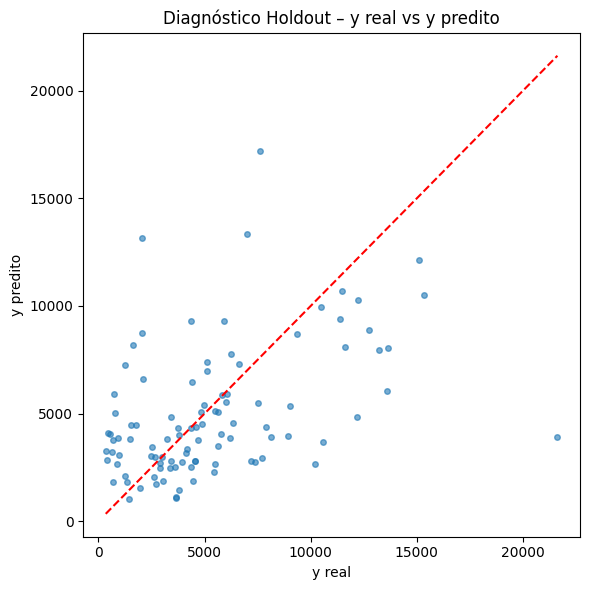

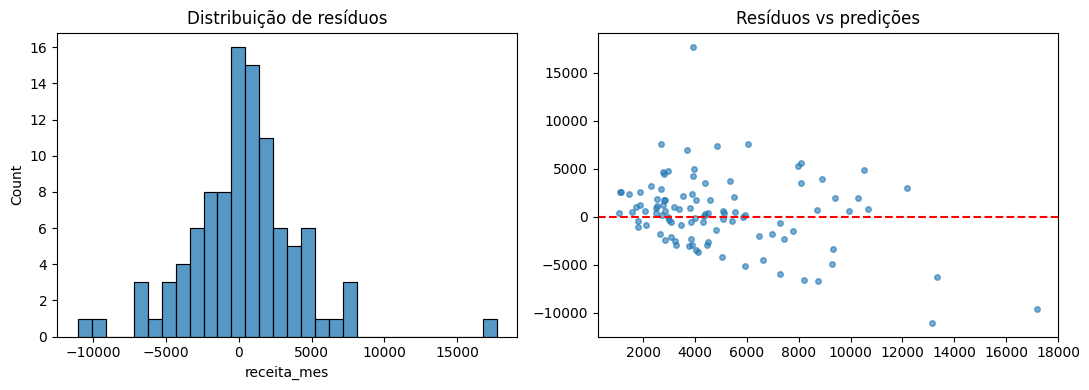

Figuras salvas em: C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita\docs\diag_holdout_scatter.png C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita\docs\diag_residuos.png


In [16]:
# Holdout rápido e gráficos profissionais: y real vs y predito; resíduos
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
model_for_diag.fit(X_train, y_train)
y_pred = model_for_diag.predict(X_test)

try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
except TypeError:
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae = float(mean_absolute_error(y_test, y_pred))
r2 = float(r2_score(y_test, y_pred))
print(f'Holdout RMSE={rmse:.3f} | MAE={mae:.3f} | R2={r2:.3f}')

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=16, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.title('Diagnóstico Holdout – y real vs y predito')
plt.xlabel('y real')
plt.ylabel('y predito')
plt.tight_layout()
fig_path1 = DOCS_DIR / 'diag_holdout_scatter.png'
plt.savefig(fig_path1, dpi=140)
plt.show()

res = y_test - y_pred
fig, axes = plt.subplots(1,2, figsize=(11,4))
sns.histplot(res, bins=30, ax=axes[0])
axes[0].set_title('Distribuição de resíduos')
axes[1].scatter(y_pred, res, s=16, alpha=0.6)
axes[1].axhline(0.0, color='r', linestyle='--')
axes[1].set_title('Resíduos vs predições')
plt.tight_layout()
fig_path2 = DOCS_DIR / 'diag_residuos.png'
plt.savefig(fig_path2, dpi=140)
plt.show()
print('Figuras salvas em:', fig_path1, fig_path2)

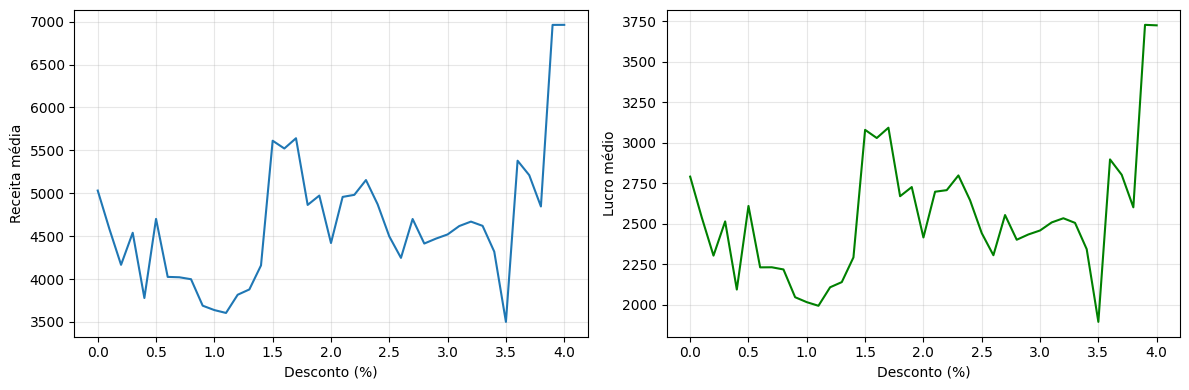

Curva de negócio publicada: C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita\docs\curve_business_metric.csv C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita\docs\curve_business_metric.png


In [17]:
# Curva de negócio vs desconto: lucro/receita médios por faixa de desconto
curve_df = business_profit_for_grid(model_for_diag, X_base, target)
curve_path = MODELS_DIR / 'curve_business_metric.csv'
curve_df.to_csv(curve_path, index=False)
curve_docs_path = DOCS_DIR / 'curve_business_metric.csv'
curve_df.to_csv(curve_docs_path, index=False)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(curve_df['desconto_pct']*100, curve_df['receita_media'], label='Receita média')
ax[0].set_xlabel('Desconto (%)')
ax[0].set_ylabel('Receita média')
ax[0].grid(True, alpha=0.3)
ax[1].plot(curve_df['desconto_pct']*100, curve_df['lucro_medio'], color='green', label='Lucro médio')
ax[1].set_xlabel('Desconto (%)')
ax[1].set_ylabel('Lucro médio')
ax[1].grid(True, alpha=0.3)
plt.tight_layout()
curve_fig_path = DOCS_DIR / 'curve_business_metric.png'
plt.savefig(curve_fig_path, dpi=140)
plt.show()
print('Curva de negócio publicada:', curve_docs_path, curve_fig_path)

In [18]:
# Política ótima por observação: desconto recomendado e lucro esperado
policy_df = per_row_optimal_discount(model_for_diag, X_sample, target)
resumo = policy_df.describe()
print(resumo)
policy_out_path = DOCS_DIR / 'policy_otima_resumo.csv'
resumo.to_csv(policy_out_path)

# Mostra top 10 observações
display(pd.concat([X_sample.reset_index(drop=True), policy_df], axis=1).head(10))
print('Política ótima resumo salvo em:', policy_out_path)

       desconto_otimo  lucro_esperado
count      500.000000      500.000000
mean         0.024854     3976.538708
std          0.016473     1859.518659
min          0.000000     1407.719136
25%          0.005000     2409.838818
50%          0.039000     3683.707084
75%          0.039000     5011.229154
max          0.040000    10099.852390


,custo_producao,preco_original,desconto_pct,preco_final,desconto_otimo,lucro_esperado
0,4.11,10.22,0.009,10.13,0.005,2271.842478
1,10.70,25.60,0.003,25.52,0.039,6426.272440
2,8.59,21.19,0.020,20.77,0.040,5582.548334
3,2.44,6.55,0.002,6.54,0.005,1972.123348
4,4.51,12.55,0.027,12.21,0.039,4053.270833
5,11.31,24.59,0.034,23.75,0.022,7121.835963
6,6.70,13.82,0.026,13.46,0.039,3901.964251
7,4.95,13.49,0.025,13.15,0.039,4448.986664
8,10.40,25.50,0.023,24.91,0.040,6591.275940
9,9.71,24.10,0.026,23.47,0.015,6929.512477


Política ótima resumo salvo em: C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita\docs\policy_otima_resumo.csv


## Observações e próximos passos
- As curvas ajudam a calibrar o teto de desconto, preservando margem.
- Recomenda-se avaliar cenários por canal e categoria, expandindo features de negócio.
- Este notebook foi desenhado para execução na CI e em ambiente local, respeitando artefatos do pipeline.

Quando você finalizar os testes deste Notebook 04, posso seguir com as instruções para concluir o MLOps com o dataset ampliado e novas features.